In [540]:
%matplotlib inline

import matplotlib
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
import pandas as pd
import datetime
import numpy
from pandas.plotting import table 

In [541]:
colors = ['b','g','r','c','m','y','k']

In [542]:
def getFormattedDfFromTimeSeries(path):
    df = pd.read_csv(path)
    df = df.drop('Lat', 1).drop('Long', 1).drop('Province/State',1)
    df = df.groupby('Country/Region').sum().sort_values(by=getDT(today), ascending=False).T
    if 'Cruise Ship' in df.columns:
        df = df.drop('Cruise Ship', 1)
    return df

In [543]:
population = pd.read_csv('~/Downloads/PopulationByCountry.csv')
population['Population'] = population['Population'].str.replace(",","").astype(int)
population.loc[population['Name'] == 'United States','Name'] = 'US'
population.loc[population['Name'] == 'United Kingdom','Name'] = 'UK'

In [544]:
df_confirmed_all = pd.read_csv('../csse_covid_19_data/csse_covid_19_time_series/time_series_19-covid-Confirmed.csv').drop('Lat', 1).drop('Long', 1)
df_confirmed = getFormattedDfFromTimeSeries('../csse_covid_19_data/csse_covid_19_time_series/time_series_19-covid-Confirmed.csv')
df_dead = getFormattedDfFromTimeSeries('../csse_covid_19_data/csse_covid_19_time_series/time_series_19-covid-Deaths.csv')
df_recovered = getFormattedDfFromTimeSeries('../csse_covid_19_data/csse_covid_19_time_series/time_series_19-covid-Recovered.csv')

In [545]:
df_active = df_confirmed.copy()
for col in df_confirmed.columns:
    df_active[col] = df_confirmed[col] - df_dead[col] - df_recovered[col]

In [546]:
def getDT(dt):
    if isinstance(dt, str):
        return dt
    return dt.strftime("%-m/%-d/%y")
def toDT(dt):
    return datetime.datetime.strptime(dt, "%m/%d/%y")
startdatetime = "1/22/20" # datetime.datetime(year=2020, month=1, day=22)
today = df_confirmed.index[-1]

In [547]:
mapping = {
    'Iran (Islamic Republic of)': 'Iran',
    'Korea, South': 'South Korea',
    'Russian Federation': 'Russia',
    'occupied Palestinian territory': 'Palestine',
    'Republic of Moldova': 'Moldova',
    'Macao SAR': 'Macau',
    'Hong Kong SAR': 'Hong Kong',
    'Saint Martin': 'St. Martin',
    'Taipei and environs': 'Taiwan',
    'Holy See': 'Vatican City',
    'Viet Nam': 'Vietnam',
}

#Mainland China

for countryName, oldCountryName in mapping.items():
    if oldCountryName in df_confirmed.columns and countryName in df_confirmed.columns:
        df_confirmed[countryName] += df_confirmed[oldCountryName]
        df_confirmed = df_confirmed.drop(oldCountryName, 1)
        
        df_death[countryName] += df_death[oldCountryName]
        df_death = df_death.drop(oldCountryName, 1)
        
        df_recovered[countryName] += df_recovered[oldCountryName]
        df_recovered = df_recovered.drop(oldCountryName, 1)
    
    if oldCountryName in population['Name'].values:
        population.loc[population['Name']==oldCountryName,'Name'] = countryName

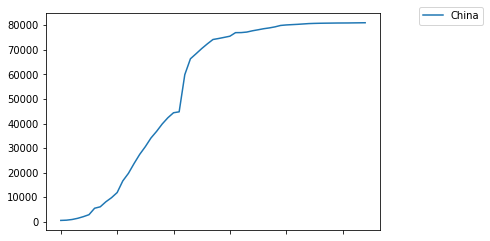

In [548]:
china = df_confirmed['China']
ax = china.plot()
ax.legend(bbox_to_anchor=(1.1, 1.05))
plt.show()

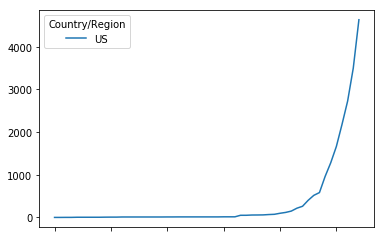

In [549]:
US = df_confirmed[['US']]
US.plot()

In [550]:
def generateAndPlotPrediction(x, y):
    f = lambda t,a,b: a * numpy.exp(b*t)
    popt, _ = curve_fit(f,  x,  y, p0=(4, 0.1))
    y_estimate = f(x, *popt)
    return lambda t: popt[0] * numpy.exp(popt[1] * t)
def generateAndPlotPredictionEstimates(x, y):
    f = lambda t,a,b: a * numpy.exp(b*t)
    popt, _ = curve_fit(f,  x,  y, p0=(4, 0.1))
    y_estimate = f(x, *popt)
    return popt

In [652]:
def addToAx(df, ax, dataFor, moredays=0, withFit=True, fromCaseNum=0, color='b'):
    df_from_case_num = df[df > fromCaseNum]
    x = np.linspace(1, len(df_from_case_num), len(df_from_case_num))
    y = df_from_case_num.values
    f = generateAndPlotPrediction(x, y)
    x2 = np.linspace(1, len(df_from_case_num) + moredays, len(df_from_case_num) + moredays)
    ax.plot(x, y, color + '-', label='data for {}'.format(dataFor))
    if withFit:
        ax.plot(x2, np.ceil(f(x2)), color + '--', label='fit for {}'.format(dataFor))
def plotCountries(df, start, end, savefilename='', moredays=0, logy=False, titlePH='confirmed', withFit=True, fromCaseNum=0):
    fig = plt.figure()
    ax = plt.subplot(111)
    for i, countryName in enumerate(df.T[start:end].T.columns):
        if countryName == 'Others':
            continue
        addToAx(df[countryName], ax, countryName, moredays=moredays, withFit=withFit, fromCaseNum=fromCaseNum, color=colors[i])
    if moredays > 0:
        plt.title('number of {} infected (COVID-19) -- from day 0 of infection in country with {} cases -- {} day prediction'.format(titlePH, fromCaseNum, moredays))
    else:
        plt.title('number of {} infected (COVID-19) -- from day 0 of infection in country with {} cases'.format(titlePH, fromCaseNum))

    if logy:
        ax.set_yscale('log')
    # Shrink current axis by 20%
    box = ax.get_position()
    ax.set_position([box.x0, box.y0, box.width * 0.8, box.height])

    # Put a legend to the right of the current axis
    lgd = ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
    plt.tight_layout()
    if savefilename:
        plt.savefig(savefilename, bbox_extra_artists=(lgd,), bbox_inches='tight')
def plotState(US_all, stateName, savefig='', moredays=0, withFit=True, fromCaseNum=0, logy=False):
    stateDf = US_all[
        US_all['Province/State'].str.contains(stateName)
    ].set_index('Province/State').T.sum(axis=1).T
    fig = plt.figure()
    ax = plt.subplot(111)
    addToAx(
        stateDf, 
        ax,
        stateName,
        moredays=moredays, 
        withFit=withFit, 
        fromCaseNum=fromCaseNum, 
        color=colors[1]
    )
    if logy:
        ax.set_yscale('log')
    plt.title("{} Infected Num".format(stateCode))
    plt.tight_layout()
    if savefig != '':
        plt.savefig(savefig, bbox_inches='tight')

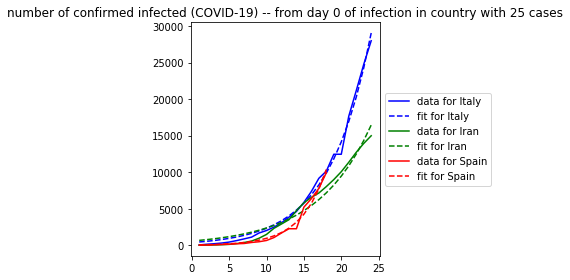

In [653]:
plotCountries(df_confirmed.T.iloc[[1, 2, 4]].T, 0, 3, 
              'Italy.Iran.Spain.png',
              moredays=0, 
              logy=False, 
              fromCaseNum=25)

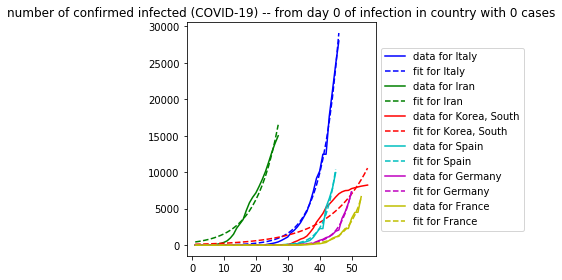

In [654]:
plotCountries(df_confirmed, 1,7, logy=False, fromCaseNum=0)

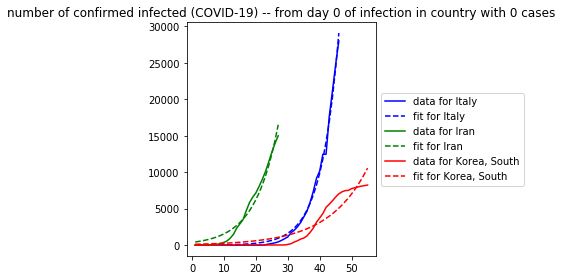

In [655]:
plotCountries(df_confirmed, 1,4, 'SK.Iran.Italy.png',moredays=0)

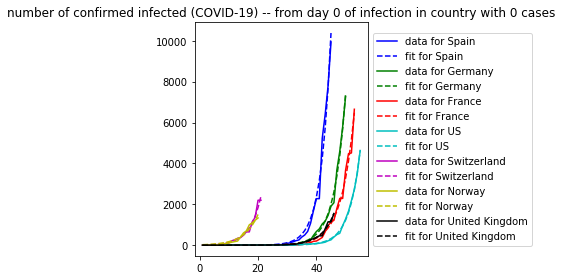

In [656]:
plotCountries(df_confirmed, 4,len(colors) + 4, '4.11.png', moredays=0)

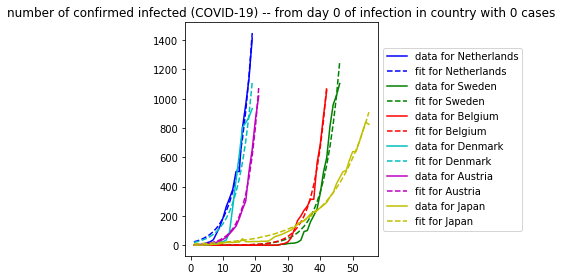

In [657]:
plotCountries(df_confirmed, len(colors) + 4, 2*len(colors) + 3, '12.18.png', moredays=0)

In [658]:
US_all = df_confirmed_all[df_confirmed_all['Country/Region'] == 'US']
US_all = US_all.drop('Country/Region', 1)

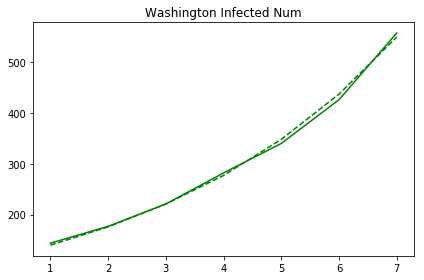

In [659]:
plotState(US_all, stateName='California', savefig='CA.png')

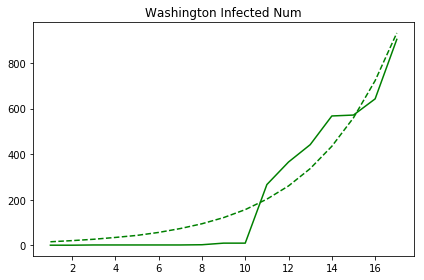

In [660]:
plotState(US_all, 'Washington', 'WA.png')

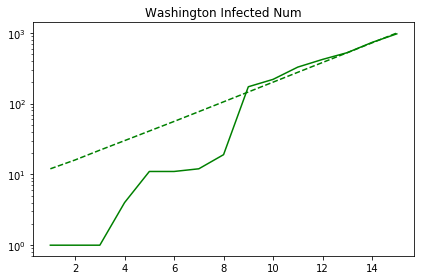

In [661]:
plotState(US_all, 'New York','NY.png',logy=True)

In [662]:
dfByPop = pd.merge(df_active.iloc[-1:].T.reset_index().rename(columns={'Country/Region':'Name'}), population, on='Name')
dfByPop = dfByPop.rename(columns={getDT(today):'InfectedNum'})
# dfByPop['Population'] = dfByPop['Population'].str.replace(",","").astype(int)
dfByPop['1 in X'] = (dfByPop['Population'] / dfByPop['InfectedNum']).replace([np.inf, -np.inf], np.nan).dropna(how="all").astype(int)
dfByPop['% Have It'] = (100 * dfByPop['InfectedNum'] / dfByPop['Population']).round(4)

success
            Name  InfectedNum    1 in X
0          Italy        23073    2620.0
1    Switzerland         2182    3966.0
2         Norway         1329    4079.0
3          Spain         9070    5154.0
4        Denmark          928    6241.0
5   Korea, South         7024    7299.0
6        Austria         1009    8926.0
7         Sweden         1096    9214.0
8         France         6490   10057.0
9        Belgium         1052   11016.0
10       Germany         7188   11656.0
11   Netherlands         1388   12345.0
12       Finland          267   20751.0
13      Portugal          328   31087.0
14        Greece          319   32674.0
15        Israel          251   34484.0
16     Singapore          134   43659.0
17      Malaysia          524   61767.0
18       Lebanon           95   71846.0
19     Australia          351   72649.0
20            US         4530   73069.0
21      Slovakia           63   86660.0
22        Canada          402   93885.0
23         Chile          155  1

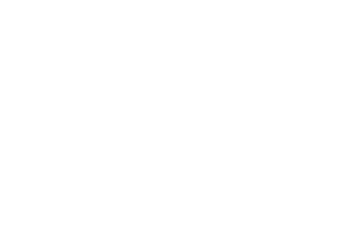

In [663]:
ax = plt.subplot(111, frame_on=False) # no visible frame
ax.xaxis.set_visible(False)  # hide the x axis
ax.yaxis.set_visible(False)  # hide the y axis

tableToPlot = dfByPop[dfByPop['Population'] > 5000000].sort_values(by='1 in X').reset_index()[['Name', 'InfectedNum', '1 in X']]

tableToPlot[:25].to_html('table.tmp.html')
title = """<h3>Active Cases By Country, 1 In X people currently have it</h3>"""
with open('table.tmp.html', 'r') as f:
    with open('table.html', 'w') as f2:
        f2.write(title + "\n")
        f2.write(f.read())
import subprocess
output = subprocess.call(
    'wkhtmltoimage -f png --width 0 table.html table.activebycountry.1inx.wkh.png', shell=True)

if output != 0:
    print("Try installing wkhtmltoimage/pdf: brew cask install wkhtmltopdf")
else:
    print("success")
    print(tableToPlot[:25])

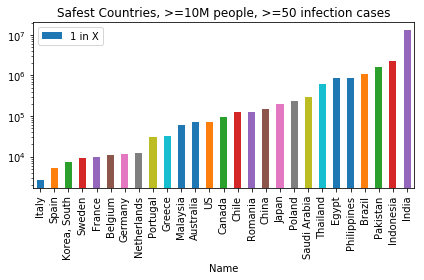

In [664]:
toPlot = dfByPop[dfByPop['Population'] >= 10e6]
toPlot = toPlot[toPlot['InfectedNum'] >= 100]
toPlot = toPlot.sort_values(by='1 in X')
toPlot[['Name', '1 in X']].plot.bar(x='Name', y='1 in X',logy=True)
plt.title('Safest Countries, >=10M people, >=50 infection cases')
plt.tight_layout()
# plt.savefig('safestCountries.1inx.png', bbox_inches='tight')

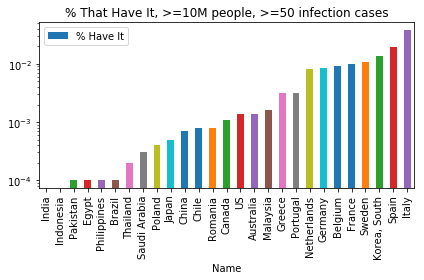

In [665]:
toPlot = dfByPop[dfByPop['Population'] >= 10e6]
toPlot = toPlot[toPlot['InfectedNum'] >= 100]
toPlot = toPlot.sort_values(by='% Have It')
toPlot[['Name', '% Have It']].plot.bar(x='Name', y='% Have It',logy=True)
plt.title('% That Have It, >=10M people, >=50 infection cases')
plt.tight_layout()
# plt.savefig('safestCountries.percenthaveit.png', bbox_inches='tight')

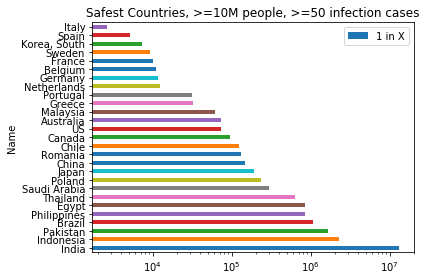

In [666]:
toPlot = dfByPop[dfByPop['Population'] >= 10e6]
toPlot = toPlot[toPlot['InfectedNum'] >= 100]
toPlot = toPlot.sort_values(by='1 in X')
toPlot[['Name', '1 in X']].iloc[::-1].plot(kind='barh', x='Name', y='1 in X', logx=True)
ax.invert_xaxis()
plt.title('Safest Countries, >=10M people, >=50 infection cases')
plt.tight_layout()
# plt.savefig('safestCountries.2.png')

In [667]:
notChina = df_confirmed.drop('China', 1)
notChina = pd.DataFrame(data=notChina.sum(axis=1).values, columns=['NumInfected'], index=notChina.index)
notChina['delta'] = notChina.diff(axis=0)
notChina = notChina.iloc[1:]
notChina['secondDiv'] = notChina['delta'] / notChina['delta'].shift()
notChina = notChina.iloc[1:]

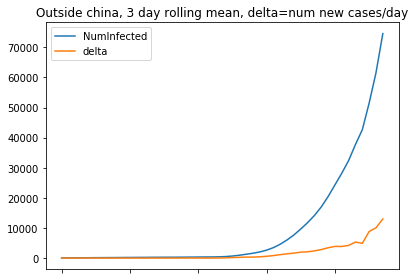

In [668]:
notChina[['NumInfected','delta']].rolling(3).mean().iloc[4:-1].plot()
plt.title("Outside china, 3 day rolling mean, delta=num new cases/day")
plt.tight_layout()
plt.savefig("outsidechina.firstderiv.png")

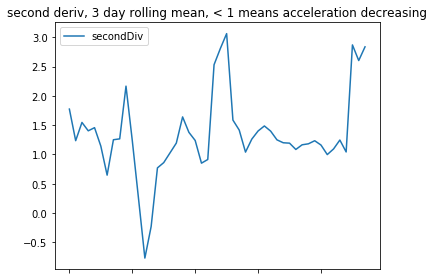

In [669]:
notChina[['secondDiv']].rolling(3).mean().iloc[4:-1].plot()
plt.title("second deriv, 3 day rolling mean, < 1 means acceleration decreasing")
plt.tight_layout()
# plt.savefig("outsidechina.secondderiv.png")

In [670]:
def predictForwardFromOthers(df, currentVal, inHowManyDays):
    avgT = 0
    avgC = 0
    for countryName in df.iloc[-1:][df.iloc[-1:] > currentVal].dropna(1).columns:
        if 'China' in countryName:
            continue
        previousValue = sum(df[countryName] > currentVal) + 1
        dfIncluding = df[countryName][-previousValue:]
        if (previousValue - 1) < inHowManyDays:
            continue
        previous, nextVal = dfIncluding.iloc[0], dfIncluding.iloc[inHowManyDays]
        avgT += (1 - (currentVal - previous)/currentVal) * (nextVal - currentVal)
        avgC += 1
    return avgT/avgC + currentVal, avgC

In [647]:
predictForwardFromOthers(df_confirmed, 4650, 2) # new york numbe rof cases

(6239.2155268817205, 5)

In [484]:
predictForwardFromOthers(df_confirmed, 328, 4)

(823.5080574912892, 14)

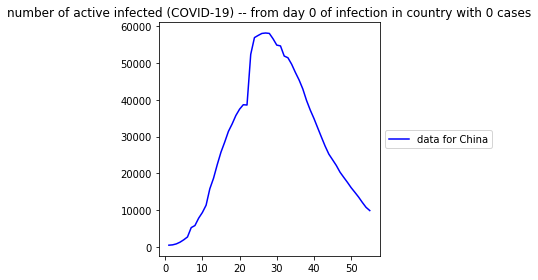

In [671]:
plotCountries(df_active, 0, 1, titlePH='active',withFit=False, savefilename='activeCasesChina.png')

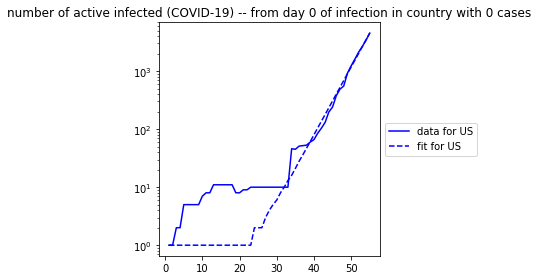

In [672]:
plotCountries(df_active, 7, 8, titlePH='active',withFit=True, logy=True, savefilename='us_active_logy.png')

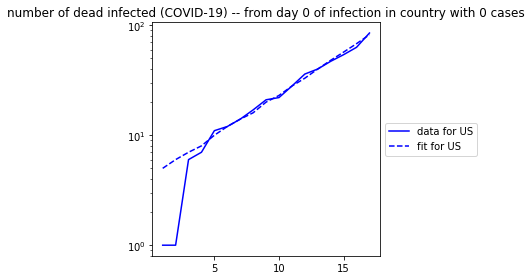

In [673]:
plotCountries(df_dead, 6, 7, titlePH='dead',withFit=True, logy=True, savefilename='us_dead_logy.png')

In [674]:
def plotStackedLine(df, title, numberOfCountries, savefigName=''):
    percentActiveDf =  df.div(df.sum(1), axis=0)
    plottingDf = percentActiveDf.T.sort_values(by=df_active.index[-1],ascending=False).iloc[:numberOfCountries].T
    plottingDf['Other'] = 1 - plottingDf.sum(axis=1)
    plottingDf.index = list(map(toDT, plottingDf.index))

    ax = plottingDf.plot.area()
    box = ax.get_position()
    ax.set_position([box.x0, box.y0, box.width * 0.8, box.height])

    # Put a legend to the right of the current axis
    lgd = ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
    plt.tight_layout()
    
    plt.title(title)

    if savefigName:
        plt.savefig(savefigName, bbox_extra_artists=(lgd,), bbox_inches='tight')

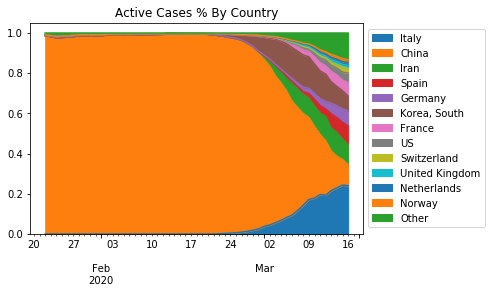

In [679]:
plotStackedLine(df_active, 'Active Cases % By Country', 12, 'stackedarea.active.all.png')

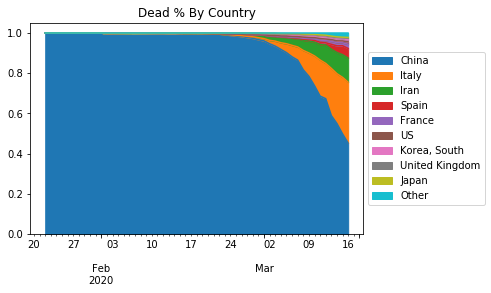

In [676]:
plotStackedLine(df_dead, 'Dead % By Country', 9, 'stackedarea.dead.all.png')

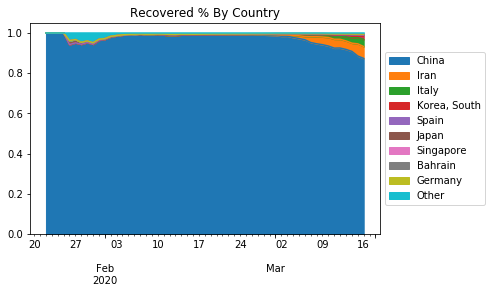

In [677]:
plotStackedLine(df_recovered, 'Recovered % By Country', 9, 'stackedarea.recovered.all.png')

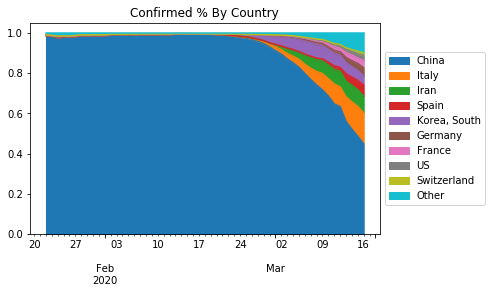

In [678]:
plotStackedLine(df_confirmed, 'Confirmed % By Country', 9, 'stackedarea.recovered.all.png')